# Project 4: Train a Face Mask Detector using YOLO V4

## 1. Overview

In the last lesson, we have learned how to train a custom Object Detector using YOLO network for a single object. In this project, you will extend that learning by building a 2-Class Object Detector using Yolo v3 as well as the more recent Yolo v4. In the process, you will also learn how to browse other GitHub repositories and find out relevant information to complete your task.

Since Covid-19 has had such a huge impact on our lives, we will build a Mask and No-mask Detector. So, the classes are:

- Class 0 - Face with Mask
- Class 1 - Face without Mask

## Loading the libraries

In [1]:
import random
import os
import json
import shutil
import numpy as np
import cv2
import matplotlib
import IPython
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['image.interpolation'] = 'bilinear'
%matplotlib inline

## Cross-Platform Environment Configuration

In [3]:
RUNNING_IN_COLAB = 'google.colab' in str(get_ipython())
RUNNING_IN_LINUX = os.name in ('posix', 'Linux')
RUNNING_IN_WIN32 = os.name in ('win32', 'nt')

print('RUNNING_IN_COLAB', RUNNING_IN_COLAB)
print('RUNNING_IN_LINUX', RUNNING_IN_LINUX)
print('RUNNING_IN_WIN32', RUNNING_IN_WIN32)

RUNNING_IN_COLAB False
RUNNING_IN_LINUX False
RUNNING_IN_WIN32 True


In [11]:
FULL_PATH = IPython.extract_module_locals()[1]['_dh'][0]

if RUNNING_IN_LINUX:
    CONTENT_PATH = FULL_PATH
    DARKNET_PATH = f'{CONTENT_PATH}/third/darknet/darknet'
    !lsb_release -a
    pass
elif RUNNING_IN_WIN32:
    CONTENT_PATH = f'{FULL_PATH}\content'
    !mkdir -p {CONTENT_PATH}
    DARKNET_PATH = 'darknet'
    pass

!nvcc --version
print('FULL_PATH', FULL_PATH)
print('CONTENT_PATH', CONTENT_PATH)
print('DARKNET_PATH', DARKNET_PATH)

J� existe uma subpasta ou um arquivo -p.
Erro ao processar: -p.


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Fri_Dec_17_18:28:54_Pacific_Standard_Time_2021
Cuda compilation tools, release 11.6, V11.6.55
Build cuda_11.6.r11.6/compiler.30794723_0
FULL_PATH c:\opencv.org\DLAP\opencv_dlap_projects\Project-04-Train-a-Face-Mask-Detector
CONTENT_PATH c:\opencv.org\DLAP\opencv_dlap_projects\Project-04-Train-a-Face-Mask-Detector\content
DARKNET_PATH darknet


## Checking nvidia instalation and cuda version

In [12]:
!nvidia-smi

Thu May  9 12:04:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.12                 Driver Version: 546.12       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   50C    P8              13W / 140W |    114MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Building Darknet

We will first make some changes to the Makefile before we compile. Specifically, we will enable the following:
1. Build darknet with OpenCV
1. Build with CUDA enabled
1. Build with cuDNN enabled.

In [13]:
if RUNNING_IN_COLAB:
  if not os.path.exists(f'{CONTENT_PATH}/third/darknet/darknet'):
    !mkdir -p '/content/third'
    %cd /content/third
    !git clone https://github.com/AlexeyAB/darknet.git
    %cd darknet
    !sed -i 's/OPENCV=0/OPENCV=1/' Makefile
    !sed -i 's/GPU=0/GPU=1/' Makefile
    !sed -i 's/CUDNN=0/CUDNN=1/' Makefile
    !sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

    print("Building. . . It might take 2-3 minutes")

    !make &> build_log.txt

  %cd {CONTENT_PATH}

  !{DARKNET_PATH} --version

## Set Here the YOLO Version

supported versions:
 - yolov3
 - yolov4

In [14]:
YOLO_VERSION = 'yolov4'
print('YOLO_VERSION', YOLO_VERSION)

YOLO_VERSION yolov4


## The Dataset

It contains images of people with mask and without mask and the annotations are given in the txt files. The Class 0 is for Face with Mask and Class 1 is for face without mask.

In [16]:
print(f'running in a {os.name} machine')
if RUNNING_IN_LINUX:
  if RUNNING_IN_COLAB:
    print('Running on CoLab')
    from google.colab import drive
    drive.mount(f'{CONTENT_PATH}/drive')
    PATH_TO_DATASET = f'{CONTENT_PATH}/drive/MyDrive/dataset/mask_no_mask_dataset'
    if not os.path.exists(f'{CONTENT_PATH}/drive/MyDrive/dataset') or not os.path.exists(f'{CONTENT_PATH}/drive/MyDrive/dataset/mask_no_mask_dataset'):
      print('Downloading the model and unzip it')
      !mkdir -p {PATH_TO_DATASET}
      !wget https://www.dropbox.com/s/uq0x32w70c390fb/mask_no-mask_dataset.zip?dl=1 -O mask_no-mask_dataset.zip
      !mv {CONTENT_PATH}/mask_no-mask_dataset.zip {PATH_TO_DATASET}/mask_no-mask_dataset.zip
      !unzip -d {PATH_TO_DATASET} {PATH_TO_DATASET}/mask_no-mask_dataset.zip
      !rm -rf {PATH_TO_DATASET}/mask_no-mask_dataset.zip
      pass
  else:
    PATH_TO_DATASET = f'{CONTENT_PATH}/dataset/mask_no_mask_dataset'
else:
  PATH_TO_DATASET = 'C:\\opencv.org\\DLAP\\datasets\\mask_no-mask_dataset'


DATASET_NAME = 'mask_no_mask_dataset'

if YOLO_VERSION == 'yolov3':
  PRE_TRAINED_WEIGHTS_NAME = "darknet53.conv.74"
else:
  PRE_TRAINED_WEIGHTS_NAME = "yolov4.conv.137"

THRESHOLD = .1
print('PATH_TO_DATASET', PATH_TO_DATASET)
print('PRE_TRAINED_WEIGHTS_NAME', PRE_TRAINED_WEIGHTS_NAME)

running in a nt machine
PATH_TO_DATASET C:\opencv.org\DLAP\datasets\mask_no-mask_dataset
PRE_TRAINED_WEIGHTS_NAME yolov4.conv.137


### Test Images and Videos
Also, download the test Images and videos on which you have to show the results.

In [17]:
TEST_PATH = f'{CONTENT_PATH}/test'

if not os.path.exists(f'{TEST_PATH}/test-image1.jpg'):
  %cd {CONTENT_PATH}
  !mkdir test
  %cd ..
  !wget https://www.dropbox.com/s/fxei8rit9v2n83s/test-image1.jpg?dl=1 -O {TEST_PATH}/test-image1.jpg
  !wget https://www.dropbox.com/s/ia1fijzr69ytpp1/test-image2.jpg?dl=1 -O {TEST_PATH}/test-image2.jpg
  !wget https://www.dropbox.com/s/g905k4r1git5kbx/test-image3.jpg?dl=1 -O {TEST_PATH}/test-image3.jpg
  !wget https://www.dropbox.com/s/90ggmiur7b8g35m/test-image4.jpg?dl=1 -O {TEST_PATH}/test-image4.jpg

if not os.path.exists(f"{CONTENT_PATH}/test/test-video1.mp4"):
  # test videos
  !wget https://www.dropbox.com/s/pds0w3z5y7w89oz/test-video1.mp4?dl=1 -O {TEST_PATH}/test-video1.mp4
  !wget https://www.dropbox.com/s/sqwu0ktdtlxtdsd/test-video2.mp4?dl=1 -O {TEST_PATH}/test-video2.mp4

c:\opencv.org\DLAP\opencv_dlap_projects\Project-04-Train-a-Face-Mask-Detector\content
c:\opencv.org\DLAP\opencv_dlap_projects\Project-04-Train-a-Face-Mask-Detector


--2024-05-09 12:04:19--  https://www.dropbox.com/s/fxei8rit9v2n83s/test-image1.jpg?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 2620:100:601d:18::a27d:512, 162.125.5.18
Connecting to www.dropbox.com (www.dropbox.com)|2620:100:601d:18::a27d:512|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /scl/fi/7ukp309nldyepo23230ov/test-image1.jpg?rlkey=ajz7tpawk67zsokwdl6x08glq&dl=1 [following]
--2024-05-09 12:04:19--  https://www.dropbox.com/scl/fi/7ukp309nldyepo23230ov/test-image1.jpg?rlkey=ajz7tpawk67zsokwdl6x08glq&dl=1
Reusing existing connection to [www.dropbox.com]:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc54d0a0fc2e67d3dd9bc7f59ef0.dl.dropboxusercontent.com/cd/0/inline/CSnyQBAh9dPGL2NFc1NAuzXKPNcYiEQthIduk_8j-41HDRn7iJlcbwgENoOLUM50jM-qElUdydS2Gbw68Opmuem4ugO4T67lh5dUJkzRp7k_ZFKfV-KLfMa2z53W8MraHSMIur10aE0FHR5tw1fYJ_uq/file?dl=1# [following]
--2024-05-09 12:04:20--  https://uc54d0a0fc2e67d3dd9bc7f59ef0.dl.dropboxusercon

## Split data between test and training

We need to create a txt file which contains the path to the images. These files will be used while setting up the training.

The data is split into train and test in the ratio of 80:20. So, we will use 80% of the data for training and the rest for testing after a few iterations of training.

In [18]:
if not os.path.exists(f'{CONTENT_PATH}/data_test.txt'):
    f_val = open(f'{CONTENT_PATH}/data_test.txt', 'w')
    f_train = open(f'{CONTENT_PATH}/data_train.txt', 'w')

    path, dirs, files = next(os.walk(PATH_TO_DATASET))
    data_size = len(files)

    ind = 0
    data_test_size = int(0.25 * data_size)
    test_array = random.sample(range(data_size), k=data_test_size)

    for file in os.listdir(PATH_TO_DATASET):
        if(file.split(".")[-1] == "jpg"):
            ind += 1

            if ind in test_array:
                f_val.write(PATH_TO_DATASET+'/'+file+'\n')
            else:
                f_train.write(PATH_TO_DATASET+'/'+file+'\n')

    f_train.close()
    f_val.close()

### Edit the config files and show the result

In [19]:
def sed(file_path, old_content, new_content):
    with open(file_path, 'r') as file:
        file_content = file.read()

    modified_content = file_content.replace(old_content, new_content)

    with open(file_path, 'w') as file:
        file.write(modified_content)

def cat(file_path):
    with open(file_path, 'r') as file:
        file_content = file.read()

    print(file_content)

def head(num_lines, file_path):
    with open(file_path, 'r') as file:
        file_content = ''.join([next(file) for _ in range(num_lines)])

    print(file_content)

In [20]:
if RUNNING_IN_LINUX:
    !head -10 /content/data_test.txt
    pass

if RUNNING_IN_WIN32:
    head(10, f'{CONTENT_PATH}\\data_test.txt')

C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/1002.jpg
C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/1005.jpg
C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/1008.jpg
C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/1013.jpg
C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/1014.jpg
C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/1016.jpg
C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/1028.jpg
C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/1037.jpg
C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/1039.jpg
C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/1041.jpg



In [21]:
if RUNNING_IN_LINUX:
    !head -10 /content/data_train.txt
    pass

if RUNNING_IN_WIN32:
    head(10, f'{CONTENT_PATH}\\data_train.txt')

C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/0.jpg
C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/100.jpg
C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/1000.jpg
C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/1001.jpg
C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/1003.jpg
C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/1004.jpg
C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/1007.jpg
C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/1009.jpg
C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/101.jpg
C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/1010.jpg



## Download weights for Convolutional backbone

When you train your own object detector, it is a good idea to leverage existing models trained on very large datasets even though the large dataset may not contain the object you are trying to detect. This process is called transfer learning.

Instead of learning from scratch, we use a pre-trained model which contains convolutional weights trained on ImageNet. Using these weights as our starting weights, our network can learn faster. We will use the pre-trained convolutional backbone.

We will download the weights file from our server as the author's server seemed slow. If you face any issues, you can download the file from the link given in the code below.

In [22]:
if not os.path.exists(f'{PATH_TO_DATASET}/{YOLO_VERSION}/{PRE_TRAINED_WEIGHTS_NAME}'):
  !mkdir -P {PATH_TO_DATASET}/{YOLO_VERSION}
  link_to_file = '19F7Do1_2fwvQRSjAEfTOUsrvn5IcEmEQ' if YOLO_VERSION == 'yolov3' else 'https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137'
  %cd {PATH_TO_DATASET}
  !mkdir {YOLO_VERSION}
  %cd {CONTENT_PATH}
  if YOLO_VERSION == 'yolov3':
    !gdown {link_to_file} -O {PATH_TO_DATASET}/{YOLO_VERSION}/{PRE_TRAINED_WEIGHTS_NAME}
  else:
    !wget {link_to_file} -O {PATH_TO_DATASET}/{YOLO_VERSION}/{PRE_TRAINED_WEIGHTS_NAME}
  pass

!echo path to: {PATH_TO_DATASET}/{YOLO_VERSION}/{PRE_TRAINED_WEIGHTS_NAME}
%cd {CONTENT_PATH}

path to: C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/yolov4/yolov4.conv.137
c:\opencv.org\DLAP\opencv_dlap_projects\Project-04-Train-a-Face-Mask-Detector\content


### Downloading configurations files for the training

In [23]:
%cd {CONTENT_PATH}

if not os.path.exists(f'{CONTENT_PATH}/mask.setup.data'):
  !gdown 1IsvwolZiiedhVYdKpgTNl2lJdyUKCI9N -O mask.setup.data
  pass

if not os.path.exists(f'{CONTENT_PATH}/{YOLO_VERSION}.cfg'):
  link_to_config = '1XbQfhAlwVEcLMGqVZK5HjzeMAhLRzos7' if YOLO_VERSION == 'yolov3' else '1v-L9CrD7mJbKSWQfxM495lzy2AGoy0bi'
  !gdown {link_to_config} -O {YOLO_VERSION}.cfg
  pass

if not os.path.exists(f'{CONTENT_PATH}/class.names'):
  !gdown 1pAT7I9ebnTJxPCwbbWFgZZ6sv5HBn7Ry -O class.names
  pass

if not os.path.exists(f'{CONTENT_PATH}/{YOLO_VERSION}_inference.cfg'):
  link_to_inference = '1kFHZ932iio_2rN9toyytfspPyVxff1_l' if YOLO_VERSION == 'yolov3' else '1veX9mOv1EJ2jIwHzcE7n0q6bWPjMJSyx'
  !gdown {link_to_inference} -O {YOLO_VERSION}_inference.cfg
  pass

!echo {CONTENT_PATH}

c:\opencv.org\DLAP\opencv_dlap_projects\Project-04-Train-a-Face-Mask-Detector\content


Downloading...
From: https://drive.google.com/uc?id=1IsvwolZiiedhVYdKpgTNl2lJdyUKCI9N
To: c:\opencv.org\DLAP\opencv_dlap_projects\Project-04-Train-a-Face-Mask-Detector\content\mask.setup.data

  0%|          | 0.00/104 [00:00<?, ?B/s]
100%|██████████| 104/104 [00:00<?, ?B/s] 
Downloading...
From: https://drive.google.com/uc?id=1v-L9CrD7mJbKSWQfxM495lzy2AGoy0bi
To: c:\opencv.org\DLAP\opencv_dlap_projects\Project-04-Train-a-Face-Mask-Detector\content\yolov4.cfg

  0%|          | 0.00/12.2k [00:00<?, ?B/s]
100%|██████████| 12.2k/12.2k [00:00<?, ?B/s]
Downloading...
From: https://drive.google.com/uc?id=1pAT7I9ebnTJxPCwbbWFgZZ6sv5HBn7Ry
To: c:\opencv.org\DLAP\opencv_dlap_projects\Project-04-Train-a-Face-Mask-Detector\content\class.names

  0%|          | 0.00/23.0 [00:00<?, ?B/s]
100%|██████████| 23.0/23.0 [00:00<?, ?B/s]
Downloading...
From: https://drive.google.com/uc?id=1veX9mOv1EJ2jIwHzcE7n0q6bWPjMJSyx
To: c:\opencv.org\DLAP\opencv_dlap_projects\Project-04-Train-a-Face-Mask-Detector\con

c:\opencv.org\DLAP\opencv_dlap_projects\Project-04-Train-a-Face-Mask-Detector\content


In [24]:
if RUNNING_IN_LINUX:
    !cat {CONTENT_PATH}/class.names
    pass

if RUNNING_IN_WIN32:
    cat(f'{CONTENT_PATH}/class.names')

with_mask
without_mask


In [25]:
if RUNNING_IN_LINUX:
    !cat {CONTENT_PATH}/mask.setup.data
    pass

if RUNNING_IN_WIN32:
    cat(f'{CONTENT_PATH}/mask.setup.data')

classes=2
train=content/data_train.txt
valid=content/data_test.txt
names=content/class.names
backup=


### Updating path values for current machine

In [26]:
if RUNNING_IN_LINUX:
    !sed -i 's|=content|=/content|' /content/mask.setup.data
    pass

if RUNNING_IN_WIN32:
    sed(f"{CONTENT_PATH}/mask.setup.data", "=content", f"={CONTENT_PATH}")

In [27]:
if RUNNING_IN_LINUX:
    !sed -i 's|backup=|backup=/content/drive/MyDrive/dataset/mask_no_mask_dataset/backup/|' /content/mask.setup.data
    pass

if RUNNING_IN_WIN32:
    sed(f"{CONTENT_PATH}/mask.setup.data", "backup=", f"backup={PATH_TO_DATASET}\\backup")

In [28]:
if RUNNING_IN_LINUX:
    !cat {CONTENT_PATH}/mask.setup.data
    pass

if RUNNING_IN_WIN32:
    cat(f"{CONTENT_PATH}/mask.setup.data")

classes=2
train=c:\opencv.org\DLAP\opencv_dlap_projects\Project-04-Train-a-Face-Mask-Detector\content/data_train.txt
valid=c:\opencv.org\DLAP\opencv_dlap_projects\Project-04-Train-a-Face-Mask-Detector\content/data_test.txt
names=c:\opencv.org\DLAP\opencv_dlap_projects\Project-04-Train-a-Face-Mask-Detector\content/class.names
backup=C:\opencv.org\DLAP\datasets\mask_no-mask_dataset\backup


In [29]:
if RUNNING_IN_LINUX:
    !head -24 {CONTENT_PATH}/{YOLO_VERSION}.cfg
    pass

if RUNNING_IN_WIN32:
    head(24, f'{CONTENT_PATH}/{YOLO_VERSION}.cfg')

[net]
batch=64
subdivisions=32
# Training
width=512
height=512
# width=608
# height=608
channels=3
momentum=0.949
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.0013
burn_in=1000
max_batches = 4000
policy=steps
steps=3200,3600
scales=.1,.1

#cutmix=1



## Training a new model or continue the training from last checkpoint

If for any reason Colab closes our session or has any problems, or if we need to interrupt training, we not need to start training from scratch. This is because every 100 iterations a file called *yolov3_custom_last.weights* is saved, within the directory you specified in "backup". And every 1000 iterations a separate .weights is saved as a backup.

To continue training where we left off we just need to put the *yolov3_custom_last.weights* path in place of the YOLO pre-trained model (darknet53.conv.74, in the case of YOLOv3)

### Modify this code if you want to download pre-trained model

In [30]:
if not os.path.exists(f'{PATH_TO_DATASET}/backup/{YOLO_VERSION}_best.weights'):
  link_to_best_weights = '1Yo8vIemwRFHvudPtX4MWEB7GP9PFbw9x' if YOLO_VERSION == 'yolov3' else '1Hu_Eu5lZXKaORSGpitJN1h9PkXy7PmjI'
  !gdown {link_to_best_weights} -O {PATH_TO_DATASET}/backup/{YOLO_VERSION}_best.weights
  pass

!echo {PATH_TO_DATASET}/backup/{YOLO_VERSION}_best.weights

C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/backup/yolov4_best.weights


In [31]:
%time
#REMOVE THIS LINE IF YOU WANT TO TRAIN FROM ZERO OR CONTINUE THE TRAINING FROM LAST SAVED WEIGHTS
if not os.path.exists(f'{PATH_TO_DATASET}/backup/{YOLO_VERSION}_best.weights'):

  if not os.path.exists(f'{PATH_TO_DATASET}/backup/{YOLO_VERSION}_best.weights'):
      !mkdir -p {PATH_TO_DATASET}/backup
      !{DARKNET_PATH} detector train {CONTENT_PATH}/mask.setup.data {CONTENT_PATH}/{YOLO_VERSION}.cfg {PATH_TO_DATASET}/{YOLO_VERSION}/{PRE_TRAINED_WEIGHTS_NAME} -dont_show -map 2> {CONTENT_PATH}/train_log.txt
      pass
  else:
      !{DARKNET_PATH} detector train {CONTENT_PATH}/mask.setup.data {CONTENT_PATH}/{YOLO_VERSION}.cfg {PATH_TO_DATASET}/backup/{YOLO_VERSION}_last.weights -dont_show -map 2> {CONTENT_PATH}/train_log.txt
      pass

CPU times: total: 0 ns
Wall time: 0 ns


### Ploting the chart of the evolution average-Loss and accuracy of mean average precision(mAP%)

In [32]:
#comment this code if you want to train again, this file bellow are from my training proccess

chart_file_name = f'{CONTENT_PATH}/chart_{YOLO_VERSION}.png'
if not os.path.exists(chart_file_name):
  link_to_pre_trained_chart = '1TjL6Xxxc3v90myn4zI_J_SQfVl68f3Yi' if YOLO_VERSION == 'yolov3' else '1UyiEWNf92igwvtftVg8hrEGoPgijx4Ec'
  !gdown {link_to_pre_trained_chart} -O {CONTENT_PATH}/chart_{YOLO_VERSION}.png

Downloading...
From: https://drive.google.com/uc?id=1UyiEWNf92igwvtftVg8hrEGoPgijx4Ec
To: c:\opencv.org\DLAP\opencv_dlap_projects\Project-04-Train-a-Face-Mask-Detector\content\chart_yolov4.png

  0%|          | 0.00/90.4k [00:00<?, ?B/s]
100%|██████████| 90.4k/90.4k [00:00<00:00, 723kB/s]
100%|██████████| 90.4k/90.4k [00:00<00:00, 723kB/s]


c:\opencv.org\DLAP\opencv_dlap_projects\Project-04-Train-a-Face-Mask-Detector\content/chart_yolov4.png True


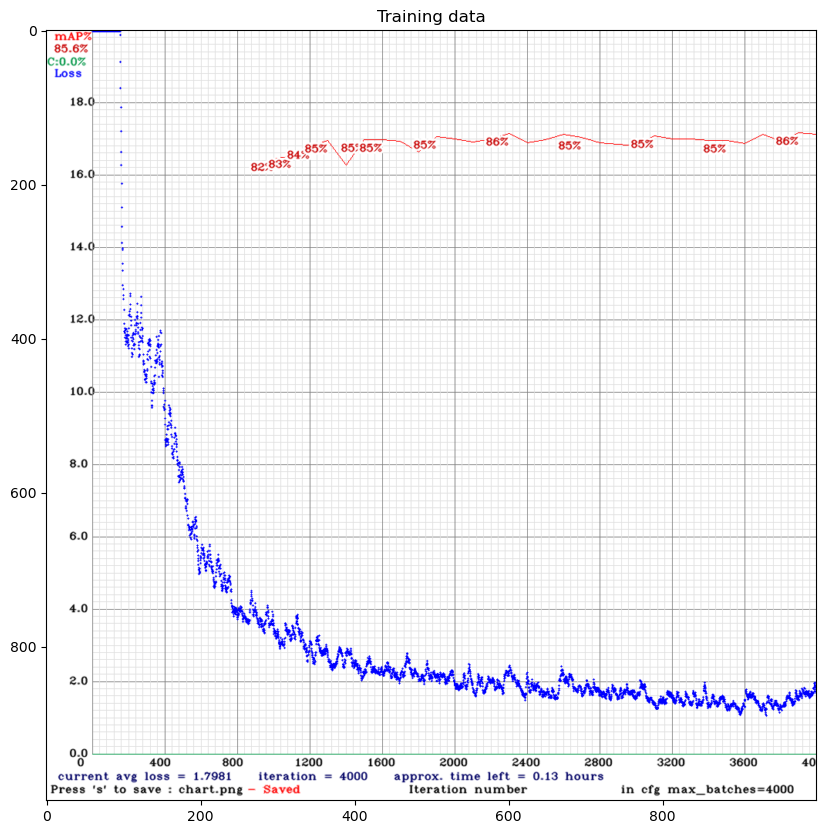

In [33]:
print(chart_file_name, os.path.exists(chart_file_name))
if os.path.exists(chart_file_name):
    img_chart = cv2.imread(chart_file_name,1)
    plt.figure(figsize=[20,10])
    plt.title("Training data")
    plt.imshow(img_chart[:,:,::-1])

## Model Mean Average Precision

In [34]:
!{DARKNET_PATH} detector map {CONTENT_PATH}/mask.setup.data {CONTENT_PATH}/{YOLO_VERSION}.cfg {PATH_TO_DATASET}/backup/{YOLO_VERSION}_best.weights

 CUDNN_HALF=1 
net.optimized_memory = 0 
mini_batch = 1, batch = 32, time_steps = 1, train = 0 
Create CUDA-stream - 0 
 Create cudnn-handle 0 
nms_kind: greedynms (1), beta = 0.600000 
nms_kind: greedynms (1), beta = 0.600000 
nms_kind: greedynms (1), beta = 0.600000 

 seen 64, trained: 249 K-images (3 Kilo-batches_64) 

 calculation mAP (mean average precision)...
 Detection layer: 139 - type = 28 
 Detection layer: 150 - type = 28 
 Detection layer: 161 - type = 28 

 detections_count = 3559, unique_truth_count = 1969  
 rank = 0 of ranks = 3559 
 rank = 100 of ranks = 3559 
 rank = 200 of ranks = 3559 
 rank = 300 of ranks = 3559 
 rank = 400 of ranks = 3559 
 rank = 500 of ranks = 3559 
 rank = 600 of ranks = 3559 
 rank = 700 of ranks = 3559 
 rank = 800 of ranks = 3559 
 rank = 900 of ranks = 3559 
 rank = 1000 of ranks = 3559 
 rank = 1100 of ranks = 3559 
 rank = 1200 of ranks = 3559 
 rank = 1300 of ranks = 3559 
 rank = 1400 of ranks = 3559 
 rank = 1500 of ranks = 3559 
 r

 CUDA-version: 11060 (12030), cuDNN: 8.3.2, CUDNN_HALF=1, GPU count: 1  
 OpenCV version: 4.5.5
 0 : compute_capability = 860, cudnn_half = 1, GPU: NVIDIA GeForce RTX 3070 Ti Laptop GPU 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    512 x 512 x   3 ->  512 x 512 x  32 0.453 BF
   1 conv     64       3 x 3/ 2    512 x 512 x  32 ->  256 x 256 x  64 2.416 BF
   2 conv     64       1 x 1/ 1    256 x 256 x  64 ->  256 x 256 x  64 0.537 BF
   3 route  1 		                           ->  256 x 256 x  64 
   4 conv     64       1 x 1/ 1    256 x 256 x  64 ->  256 x 256 x  64 0.537 BF
   5 conv     32       1 x 1/ 1    256 x 256 x  64 ->  256 x 256 x  32 0.268 BF
   6 conv     64       3 x 3/ 1    256 x 256 x  32 ->  256 x 256 x  64 2.416 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 256 x 256 x  64 0.004 BF
   8 conv     64       1 x 1/ 1    256 x 256 x  64 ->  256 x 256 x  64 0.537 BF
   9 route  8 2 	                           ->

# Running the inference using darknet

In [35]:
def move_predicted_output(src, dst):
    shutil.move(src, dst)

def display_output(imagePath):
    src = cv2.imread(imagePath,1)
    output = cv2.imread("predictions.jpg")

    plt.figure(figsize=[15,15])
    plt.subplot(121)
    plt.imshow(src[:,:,::-1])
    plt.title("Original Image")
    plt.subplot(122)
    plt.imshow(output[:,:,::-1])
    plt.title("Predictions")
    plt.show()

def get_all_test_images(test_path):
    all_tests = [f for f in os.listdir(test_path) if not f.endswith('-pred.jpg') and f.endswith('jpg')]
    with open(f'{test_path}/image_test_files.txt', "w") as file:
        for file_name in all_tests:
            file.write(test_path+'/'+file_name + "\n")

    return all_tests

def load_all_images(img_path):
    images = []
    all_images = [f for f in os.listdir(img_path) if f.endswith('.jpg') ]
    all_images = sorted(all_images)
    for file_name in all_images:
        img = cv2.imread(img_path+'/'+file_name)
        images.append(img)
    return images


def show_all_images(images):
    plt.figure(figsize=[20,20])
    plt.subplot(421);plt.imshow(images[1][:,:,::-1]);plt.title("test-img1")
    plt.subplot(422);plt.imshow(images[0][:,:,::-1]);plt.title("pred-img1")
    plt.subplot(423);plt.imshow(images[3][:,:,::-1]);plt.title("test-img2")
    plt.subplot(424);plt.imshow(images[2][:,:,::-1]);plt.title("pred-img2")
    plt.subplot(425);plt.imshow(images[5][:,:,::-1]);plt.title("test-img3")
    plt.subplot(426);plt.imshow(images[4][:,:,::-1]);plt.title("pred-img3")
    plt.subplot(427);plt.imshow(images[7][:,:,::-1]);plt.title("test-img4")
    plt.subplot(428);plt.imshow(images[6][:,:,::-1]);plt.title("pred-img4")

#### Running all test images at once

 CUDNN_HALF=1 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
Create CUDA-stream - 0 
 Create cudnn-handle 0 
nms_kind: greedynms (1), beta = 0.600000 
nms_kind: greedynms (1), beta = 0.600000 
nms_kind: greedynms (1), beta = 0.600000 

 seen 64, trained: 249 K-images (3 Kilo-batches_64) 
 Detection layer: 139 - type = 28 
 Detection layer: 150 - type = 28 
 Detection layer: 161 - type = 28 
c:\opencv.org\DLAP\opencv_dlap_projects\Project-04-Train-a-Face-Mask-Detector\content/test/test-image1.jpg: Predicted in 1392.310000 milli-seconds.
with_mask: 100%
 CUDNN_HALF=1 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
Create CUDA-stream - 0 
 Create cudnn-handle 0 
nms_kind: greedynms (1), beta = 0.600000 
nms_kind: greedynms (1), beta = 0.600000 
nms_kind: greedynms (1), beta = 0.600000 

 seen 64, trained: 249 K-images (3 Kilo-batches_64) 
 Detection layer: 139 - type = 28 
 Detection layer: 150 - type = 28 
 Detection laye

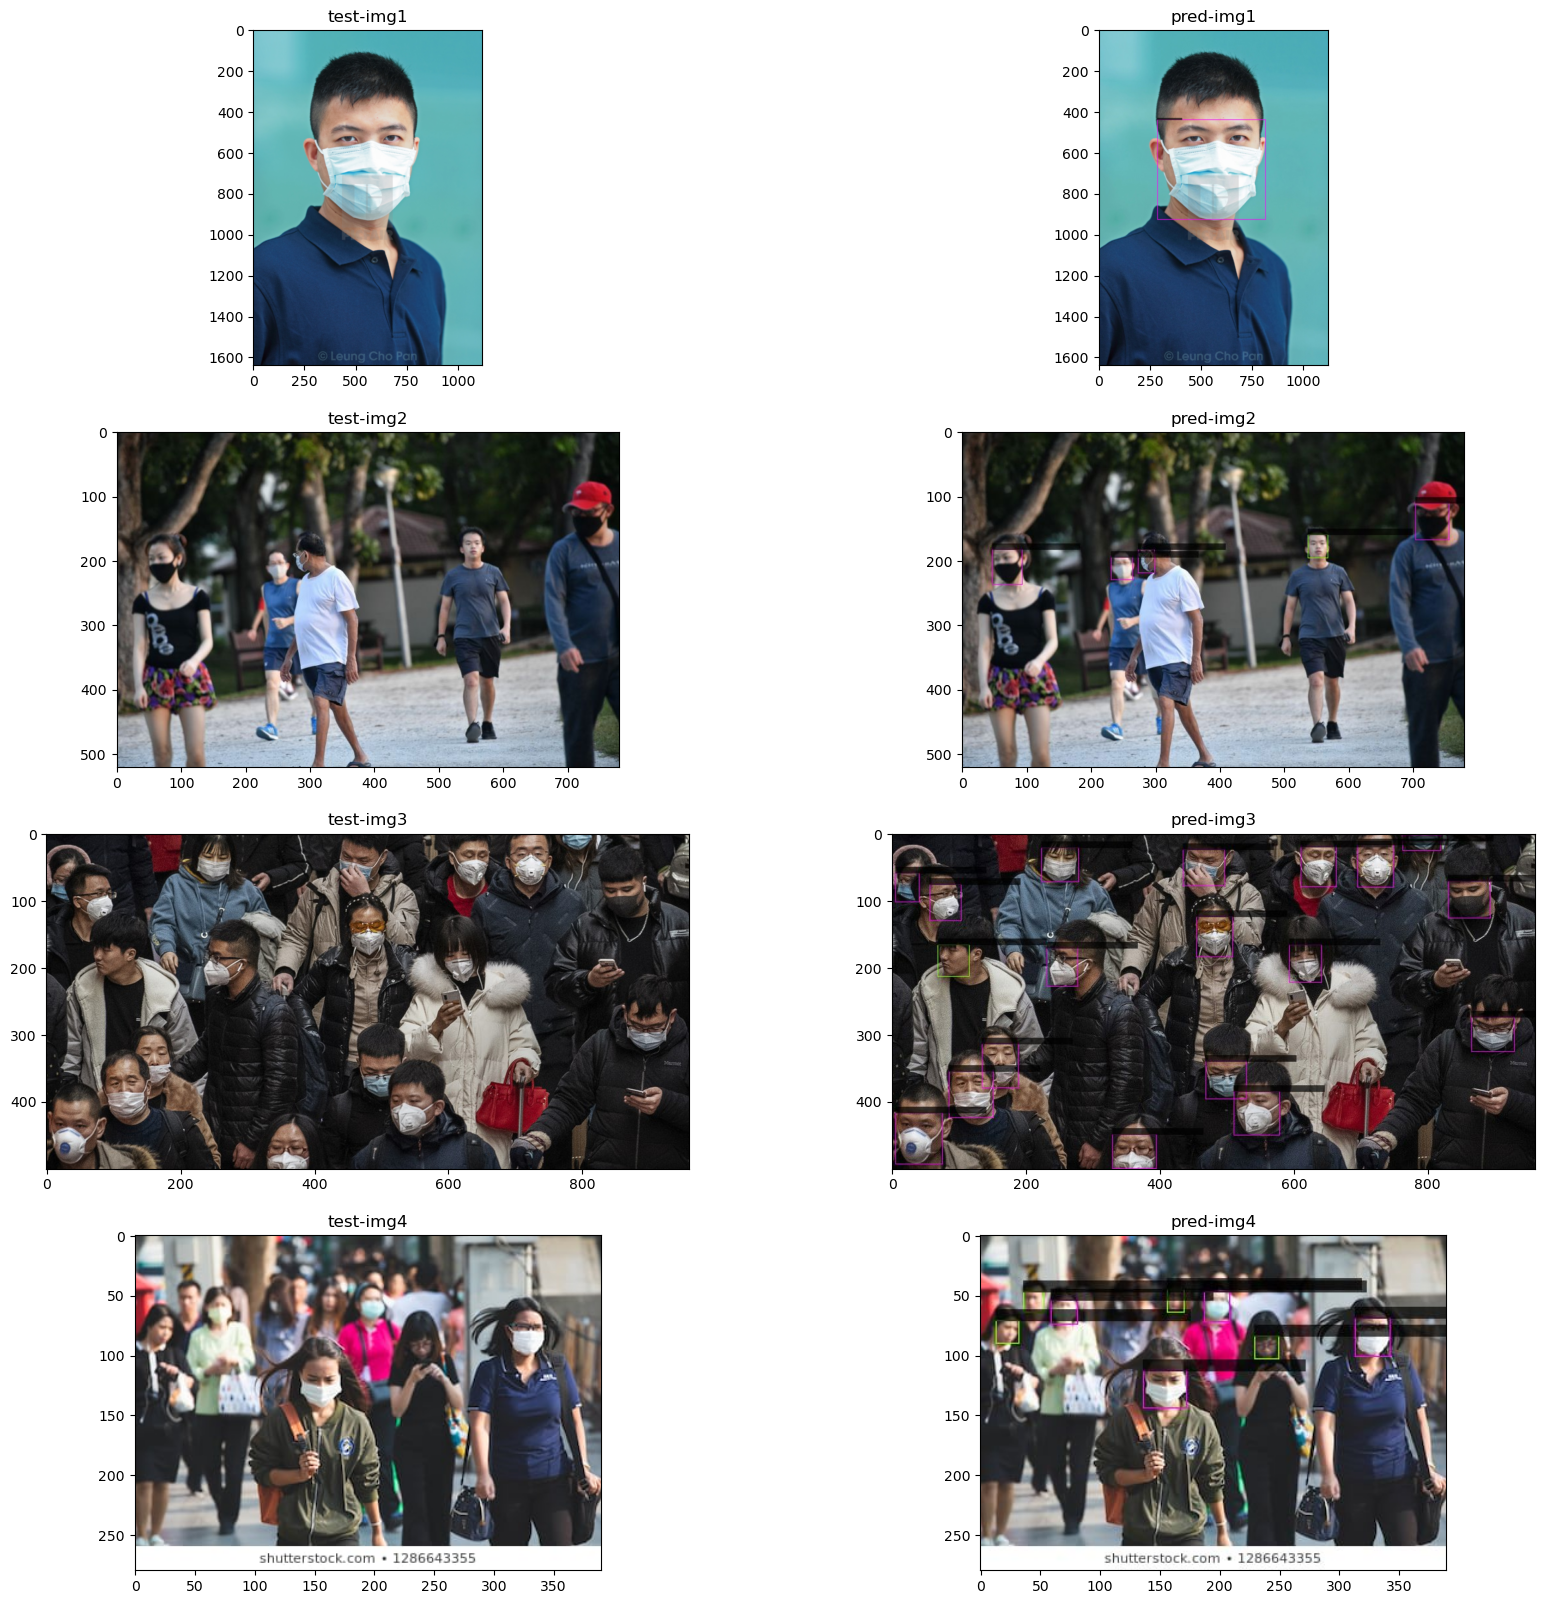

In [36]:
all_test_images = get_all_test_images(TEST_PATH)
for image in all_test_images:
    !{DARKNET_PATH} detector test \
    {CONTENT_PATH}/mask.setup.data \
    {CONTENT_PATH}/{YOLO_VERSION}_inference.cfg \
    {PATH_TO_DATASET}/backup/{YOLO_VERSION}_best.weights \
    {CONTENT_PATH}/test/{image} \
    -dont_show -save_labels -thresh .6 2> /dev/null

    pred_name = image.replace('.jpg', '-pred.jpg')

    move_predicted_output('predictions.jpg', f'{CONTENT_PATH}/test/{pred_name}')

images = load_all_images(TEST_PATH)
show_all_images(images)

### Annotating images with OpenCV using the output text-file

Text(0.5, 1.0, 'pred-img4')

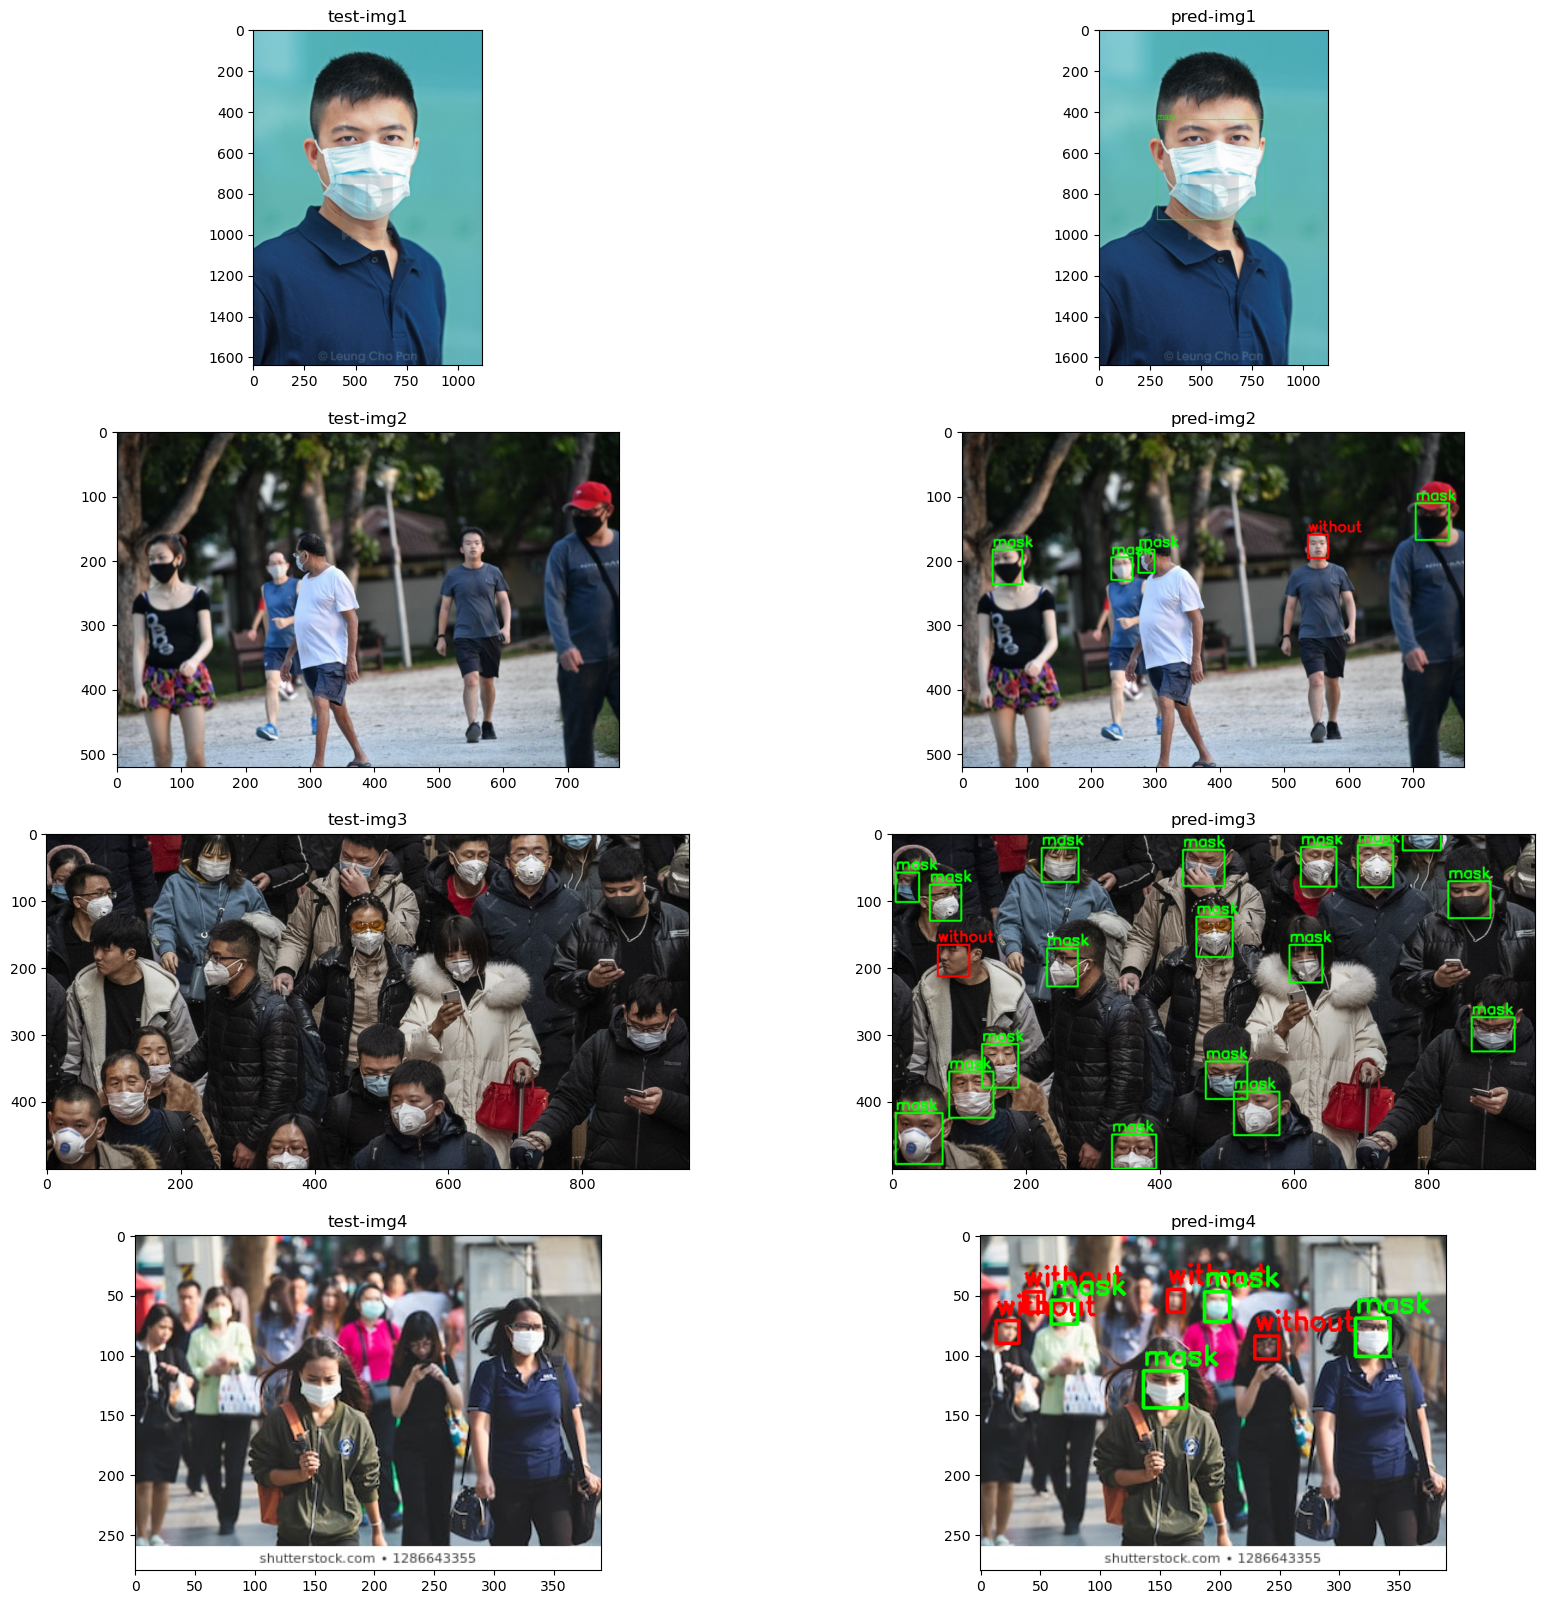

In [37]:
def draw_boxes(image, detections):
    class_labels = ['mask', 'without']
    thickness = adjust_thickness(image.shape[1], image.shape[0])
    font_size = adjust_font_size(image.shape[1], image.shape[0])
    for class_index, left, top, right, bottom in detections:
        colors = [(0, 255, 0), (0, 0, 255)]
        cv2.rectangle(image, (left, top), (right, bottom), colors[class_index], thickness)
        cv2.putText(image, class_labels[class_index], (left, top-5), cv2.FONT_HERSHEY_SIMPLEX, font_size, colors[class_index], thickness)
    return image

def adjust_thickness(image_width, image_height):
    thickness = int(min(image_width, image_height) / 400)
    return max(thickness, 2)

def adjust_font_size(image_width, image_height):
    font_size = min(image_width, image_height) / 1000
    return max(font_size, 0.75)

def parse_darknet_detection(output_text, image_width, image_height):
    lines = output_text.strip().split("\n")
    detections = []
    for line in lines:
        parts = line.split()
        class_index = int(parts[0])
        x, y, w, h = map(float, parts[1:])
        left = int((x - w / 2) * image_width)
        top = int((y - h / 2) * image_height)
        right = int((x + w / 2) * image_width)
        bottom = int((y + h / 2) * image_height)
        detections.append((class_index, left, top, right, bottom))
    return detections

all_images = []
all_test_images = get_all_test_images(TEST_PATH)
for image in all_test_images:

    text_file = image.replace('.jpg', '.txt')
    file_content = ''
    with open(f'{CONTENT_PATH}/test/{text_file}', 'r') as f:
        file_content = f.read()

    img = cv2.imread(f'{CONTENT_PATH}/test/{image}')
    detections = parse_darknet_detection(file_content, img.shape[1], img.shape[0])
    predicted = draw_boxes(img.copy(), detections)
    all_images.append(img)
    all_images.append(predicted)

plt.figure(figsize=[20,20])
plt.subplot(421);plt.imshow(all_images[0][:,:,::-1]);plt.title("test-img1")
plt.subplot(422);plt.imshow(all_images[1][:,:,::-1]);plt.title("pred-img1")
plt.subplot(423);plt.imshow(all_images[2][:,:,::-1]);plt.title("test-img2")
plt.subplot(424);plt.imshow(all_images[3][:,:,::-1]);plt.title("pred-img2")
plt.subplot(425);plt.imshow(all_images[4][:,:,::-1]);plt.title("test-img3")
plt.subplot(426);plt.imshow(all_images[5][:,:,::-1]);plt.title("pred-img3")
plt.subplot(427);plt.imshow(all_images[6][:,:,::-1]);plt.title("test-img4")
plt.subplot(428);plt.imshow(all_images[7][:,:,::-1]);plt.title("pred-img4")

## Initialize class labels

In [38]:
class_labels = ['mask', 'no_mask']
print("class_labels", class_labels)

class_labels ['mask', 'no_mask']


### Initialize box colors by classes

In [39]:
class_colors = ["0,255,0","0,0,255"]
class_colors = [np.array(every_color.split(",")).astype("int") for every_color in class_colors]
class_colors = np.array(class_colors)
class_colors = np.tile(class_colors,(7,1))

# Processing Video Files

### The input version

In [40]:
%%HTML
<div style="width: 100%; overflow: hidden;">

<div style="width: 600px; float: left;">
<span>video 1</span></br>
<video controls>
    <source src='content/test/test-video1.mp4' type="video/mp4">
</video>
</div>

<div style="margin-left: 620px;">
<span>video 2</span></br>
<video controls>
    <source src='content/test/test-video2.mp4' type="video/mp4">
</video>

</div>
</div>

#### processing video files using darknet detector demo and annotate output video using OpenCV

In [41]:
if RUNNING_IN_LINUX:
  writer_codec = cv2.VideoWriter_fourcc('F','M','P','4')
else:
  writer_codec = cv2.VideoWriter_fourcc('H','2','6','4')

In [42]:
def video_annotations_from_json(image, detections, class_labels):
    colors = [(0, 255, 0), (0, 0, 255)]  # Example colors
    thickness = adjust_thickness(image.shape[1], image.shape[0])
    font_size = adjust_font_size(image.shape[1], image.shape[0])
    frame_id = detections["frame_id"]
    objects = detections["objects"]
    for obj_info in objects:
        class_id = obj_info["class_id"]
        class_name = class_labels[class_id]
        relative_coordinates = obj_info["relative_coordinates"]
        confidence = obj_info["confidence"]

        left = int((relative_coordinates["center_x"] - relative_coordinates["width"] / 2) * image.shape[1])
        top = int((relative_coordinates["center_y"] - relative_coordinates["height"] / 2) * image.shape[0])
        right = int((relative_coordinates["center_x"] + relative_coordinates["width"] / 2) * image.shape[1])
        bottom = int((relative_coordinates["center_y"] + relative_coordinates["height"] / 2) * image.shape[0])

        color = colors[class_id % len(colors)]
        cv2.rectangle(image, (left, top), (right, bottom), color, thickness)
        cv2.putText(image, f"{class_name}: {confidence:.2f}", (left, top-5), cv2.FONT_HERSHEY_SIMPLEX, font_size, color, thickness)
    return image

def process_video_file(input_file):
  video_file = f'{CONTENT_PATH}/test/{input_file}'
  default_name = os.path.splitext(input_file)[0]
  output_directory = f'{CONTENT_PATH}/test/{default_name}'
  if not os.path.exists(output_directory):
    os.makedirs(output_directory)

  !{DARKNET_PATH} detector demo \
  {CONTENT_PATH}/mask.setup.data \
  {CONTENT_PATH}/{YOLO_VERSION}_inference.cfg \
  {PATH_TO_DATASET}/backup/{YOLO_VERSION}_best.weights \
  -ext_output -dont_show -save_labels -thresh .51 -i 0 \
  {video_file} \
  -json_file_output {output_directory}/{default_name}.json

  reference_video = cv2.VideoCapture(video_file)
  if (reference_video.isOpened()== False):
    print("Error opening video stream or file")
    return

  fourcc = reference_video.get(cv2.CAP_PROP_FOURCC)
  codec = "".join([chr((int(fourcc) >> 8 * i) & 0xFF) for i in range(4)])
  print("video_file", video_file, "codec", codec)

  width = int(reference_video.get(cv2.CAP_PROP_FRAME_WIDTH))
  height = int(reference_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
  frame_count = int(reference_video.get(cv2.CAP_PROP_FRAME_COUNT))
  fps = reference_video.get(cv2.CAP_PROP_FPS)
  out_filename= f'{output_directory}/{default_name}_result.mp4'

  output_video_writer = cv2.VideoWriter(filename=out_filename,
                                fourcc=writer_codec,
                                frameSize=(width, height), fps=fps)

  json_metadata = None
  with open(f'{output_directory}/{default_name}.json', "r") as json_file:
      json_metadata = json.load(json_file)


  print('len(json_metadata)', len(json_metadata), 'frame_count', frame_count)

  frame_index = 0
  while reference_video.isOpened() and frame_index < len(json_metadata):
    ret, frame = reference_video.read()
    if not ret:
        break

    annotated_frame = video_annotations_from_json(frame, json_metadata[frame_index], class_labels)
    output_video_writer.write(annotated_frame)
    frame_index += 1

  reference_video.release()
  output_video_writer.release()

process_video_file('test-video1.mp4')
process_video_file('test-video2.mp4')

 CUDA-version: 11060 (12030), cuDNN: 8.3.2, CUDNN_HALF=1, GPU count: 1  
 OpenCV version: 4.5.5
[ WARN:0@0.140] global C:\Program Files\opencv\opencv-4.5.5\modules\imgcodecs\src\loadsave.cpp (239) cv::findDecoder imread_('data/labels/32_0.png'): can't open/read file: check file path/integrity
Cannot load image data/labels/32_0.png
[ WARN:0@0.140] global C:\Program Files\opencv\opencv-4.5.5\modules\imgcodecs\src\loadsave.cpp (239) cv::findDecoder imread_('data/labels/33_0.png'): can't open/read file: check file path/integrity
Cannot load image data/labels/33_0.png
[ WARN:0@0.140] global C:\Program Files\opencv\opencv-4.5.5\modules\imgcodecs\src\loadsave.cpp (239) cv::findDecoder imread_('data/labels/34_0.png'): can't open/read file: check file path/integrity
Cannot load image data/labels/34_0.png
[ WARN:0@0.141] global C:\Program Files\opencv\opencv-4.5.5\modules\imgcodecs\src\loadsave.cpp (239) cv::findDecoder imread_('data/labels/35_0.png'): can't open/read file: check file path/integ

 CUDNN_HALF=1 
Demo
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
Create CUDA-stream - 0 
 Create cudnn-handle 0 
nms_kind: greedynms (1), beta = 0.600000 
nms_kind: greedynms (1), beta = 0.600000 
nms_kind: greedynms (1), beta = 0.600000 

 seen 64, trained: 249 K-images (3 Kilo-batches_64) 
video file: c:\opencv.org\DLAP\opencv_dlap_projects\Project-04-Train-a-Face-Mask-Detector\content/test/test-video1.mp4
Video stream: 1600 x 842 
Objects:


FPS:0.0 	 AVG_FPS:0.0
Objects:

without_mask: 100% 	(left_x:  374   top_y:  266   width:  133   height:  169)
without_mask: 100% 	(left_x:  916   top_y:  333   width:  125   height:  168)
without_mask: 100% 	(left_x: 1159   top_y:  363   width:  153   height:  210)
without_mask: 100% 	(left_x:  692   top_y:  477   width:  146   height:  190)
without_mask: 98% 	(left_x:  777   top_y:  176   width:   53   height:   72)

FPS:4.5 	 AVG_FPS:0.0
Objects:

without_mask: 100% 	(left_x:  374   top_y:  268   width:  133 

 CUDA-version: 11060 (12030), cuDNN: 8.3.2, CUDNN_HALF=1, GPU count: 1  
 OpenCV version: 4.5.5
[ WARN:0@0.097] global C:\Program Files\opencv\opencv-4.5.5\modules\imgcodecs\src\loadsave.cpp (239) cv::findDecoder imread_('data/labels/32_0.png'): can't open/read file: check file path/integrity
Cannot load image data/labels/32_0.png
[ WARN:0@0.097] global C:\Program Files\opencv\opencv-4.5.5\modules\imgcodecs\src\loadsave.cpp (239) cv::findDecoder imread_('data/labels/33_0.png'): can't open/read file: check file path/integrity
Cannot load image data/labels/33_0.png
[ WARN:0@0.097] global C:\Program Files\opencv\opencv-4.5.5\modules\imgcodecs\src\loadsave.cpp (239) cv::findDecoder imread_('data/labels/34_0.png'): can't open/read file: check file path/integrity
Cannot load image data/labels/34_0.png
[ WARN:0@0.097] global C:\Program Files\opencv\opencv-4.5.5\modules\imgcodecs\src\loadsave.cpp (239) cv::findDecoder imread_('data/labels/35_0.png'): can't open/read file: check file path/integ

 CUDNN_HALF=1 
Demo
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
Create CUDA-stream - 0 
 Create cudnn-handle 0 
nms_kind: greedynms (1), beta = 0.600000 
nms_kind: greedynms (1), beta = 0.600000 
nms_kind: greedynms (1), beta = 0.600000 

 seen 64, trained: 249 K-images (3 Kilo-batches_64) 
video file: c:\opencv.org\DLAP\opencv_dlap_projects\Project-04-Train-a-Face-Mask-Detector\content/test/test-video2.mp4
Video stream: 1280 x 718 
Objects:


FPS:0.0 	 AVG_FPS:0.0
Objects:

without_mask: 93% 	(left_x:  788   top_y:  331   width:   25   height:   28)
without_mask: 81% 	(left_x:  735   top_y:  378   width:   15   height:   20)
without_mask: 76% 	(left_x:  654   top_y:  364   width:   14   height:   18)
without_mask: 72% 	(left_x:  341   top_y:  356   width:   16   height:   21)
with_mask: 97% 	(left_x:  979   top_y:  321   width:   29   height:   34)

FPS:4.7 	 AVG_FPS:0.0
Objects:

without_mask: 98% 	(left_x:  794   top_y:  327   width:   24   height

#### Show output videos

If you can't see the videos due of Google Colab impatibility, download the videos locally to your local machine and watch them with your favorite player.

Test Video 1 personal output 
https://youtu.be/g0cwUCYHHjk


Test Video 2 personal output 
https://youtu.be/rLvYi5HAZ6I


In [2]:
%%HTML
<div style="width: 100%; overflow: hidden;">

<div style="width: 600px; float: left;">
<span>video 1</span></br>
<video controls>
    <source src='content/test/test-video1/test-video1_result.mp4' type="video/mp4">
</video>
</div>

<div style="margin-left: 620px;">
<span>video 2</span></br>
<video controls>
    <source src='content/test/test-video2/test-video2_result.mp4' type="video/mp4">
</video>

</div>
</div>